# Online Payment Fraud Detection Project

In this project we try to detect online payment frauds with Machine Learning models. We will compare and evaluate different models to detect if a transaction is fraudolent or not, by training these models on a dataset containing more than 6 millions data points.
This is a Classification Task in a Supervised Learning environment, the model will need to recognize whether the transaction is fraudolent or not by detecting abnormal activities in the input features.

## Splitting training/test set

We need to split our dataset even before doing any other analysis because otherwise there's a high chance of overfitting, this would happen because the feature engineering would happen on the whole dataset. Another reason is that we would lose the ability of getting an unbiased performance evaluation of our model, this means that when the model would see some new data it's performance would decrease from our test set predictions.

In [33]:
# Let's import the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from cfmatrix import make_confusion_matrix
from sklearn.decomposition import PCA
import tensorflow as tf
tf.get_logger().setLevel(tf._logging.ERROR)
from scikeras.wrappers import KerasClassifier
import keras_tuner

In [34]:
df = pd.read_csv("onlinefraud.csv")

In [35]:
train_set, test_set = train_test_split(df, test_size=0.1)

## Data exploration

In this section we will explore the dataset by analyzing each feature and the relationships with each other

We import our dataset and visualize the first couple of rows

In [36]:
def plot_table(df, n=4):
    fig, ax = plt.subplots()

    # hide axes
    fig.patch.set_visible(False)
    ax.axis('off')
    # ax.axis('tight')

    table = ax.table(cellText=df.values[:n,:], colLabels=df.columns, loc='center')
    table.set_fontsize(40)
    table.scale(10.0, 10.0)

    # fig.tight_layout()
    plt.show()

### Exploring features

We can now analyze each feature and detect correlations. The following is the list of columns:
- step: it represents a unit of time where 1 step equals 1 hour
- type: type of online transaction
- amount: the amount of the transaction
- nameOrig: customer starting the transaction
- oldbalanceOrg: balance of customer before the transaction
- newbalanceOrig: balance of customer after the transaction
- nameDest: receiver customer of the transaction
- oldbalanceDest: initial balance of receiver customer before the transaction
- newbalanceDest: the new balance of receiver customer after the transaction
- isFraud: fraud transaction, this is the target label
- isFlaggedFraud: this feature is not described in the dataset description

We can visualize some of the most interesting features

#### Step

It represents a unit of time where 1 step equals 1 hour, in the following graph we can see the time distribution.

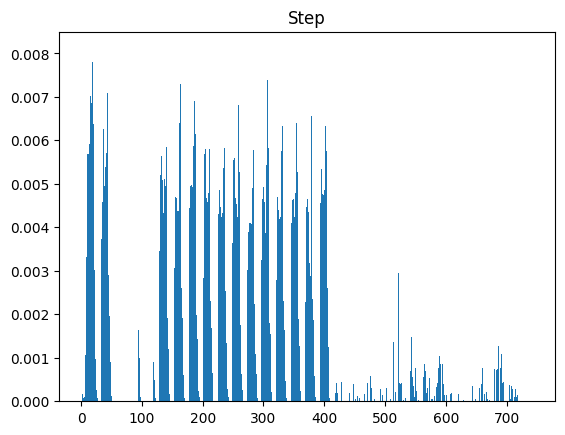

In [38]:
step = train_set["step"]
max_hours = step.max()

plt.title('Step')
plt.hist(step, max_hours, density=True)
plt.show()

#### Type

It represents a type of online transaction, there are 5 classes:
- CASH_OUT
- PAYMENT
- CASH_IN
- TRANSFER
- DEBIT

We can plot its distribution and check which one is the most frequent in our dataset.

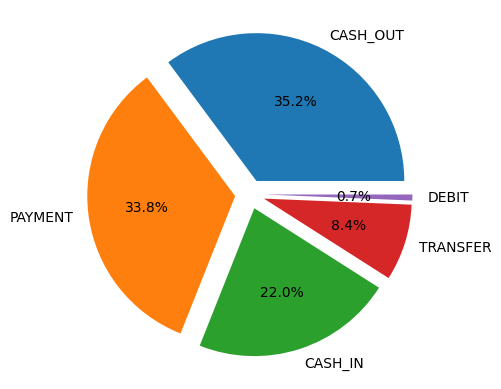

In [39]:
type = train_set["type"].value_counts()
transaction_names = type.index.to_list()
quantity = type.values
expl = np.array([0.1, 0.1, 0.1, 0.1, 0.1])
figure = plt.pie(quantity, labels=transaction_names, explode=expl, autopct='%1.1f%%')
plt.show()

It looks like most of the transactions are either CASH_OUT or PAYMENT, so the majority of frauds will be of one of this two categories.

#### isFraud

We can notice from the graphs below that this feature is imbalanced, which is not ideal for a classification task. We will discuss about the consequences and how to improve it later

,isFraud
isFraud,
0,5718910
1,7448


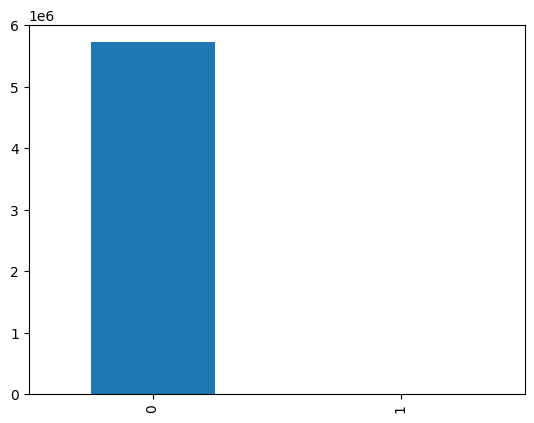

In [40]:
train_set["isFraud"].value_counts().plot(kind='bar')
pd.pivot_table(train_set, index=train_set["isFraud"], values='isFraud', aggfunc='count')

#### Amount

Let's see the 100 largest transaction imports

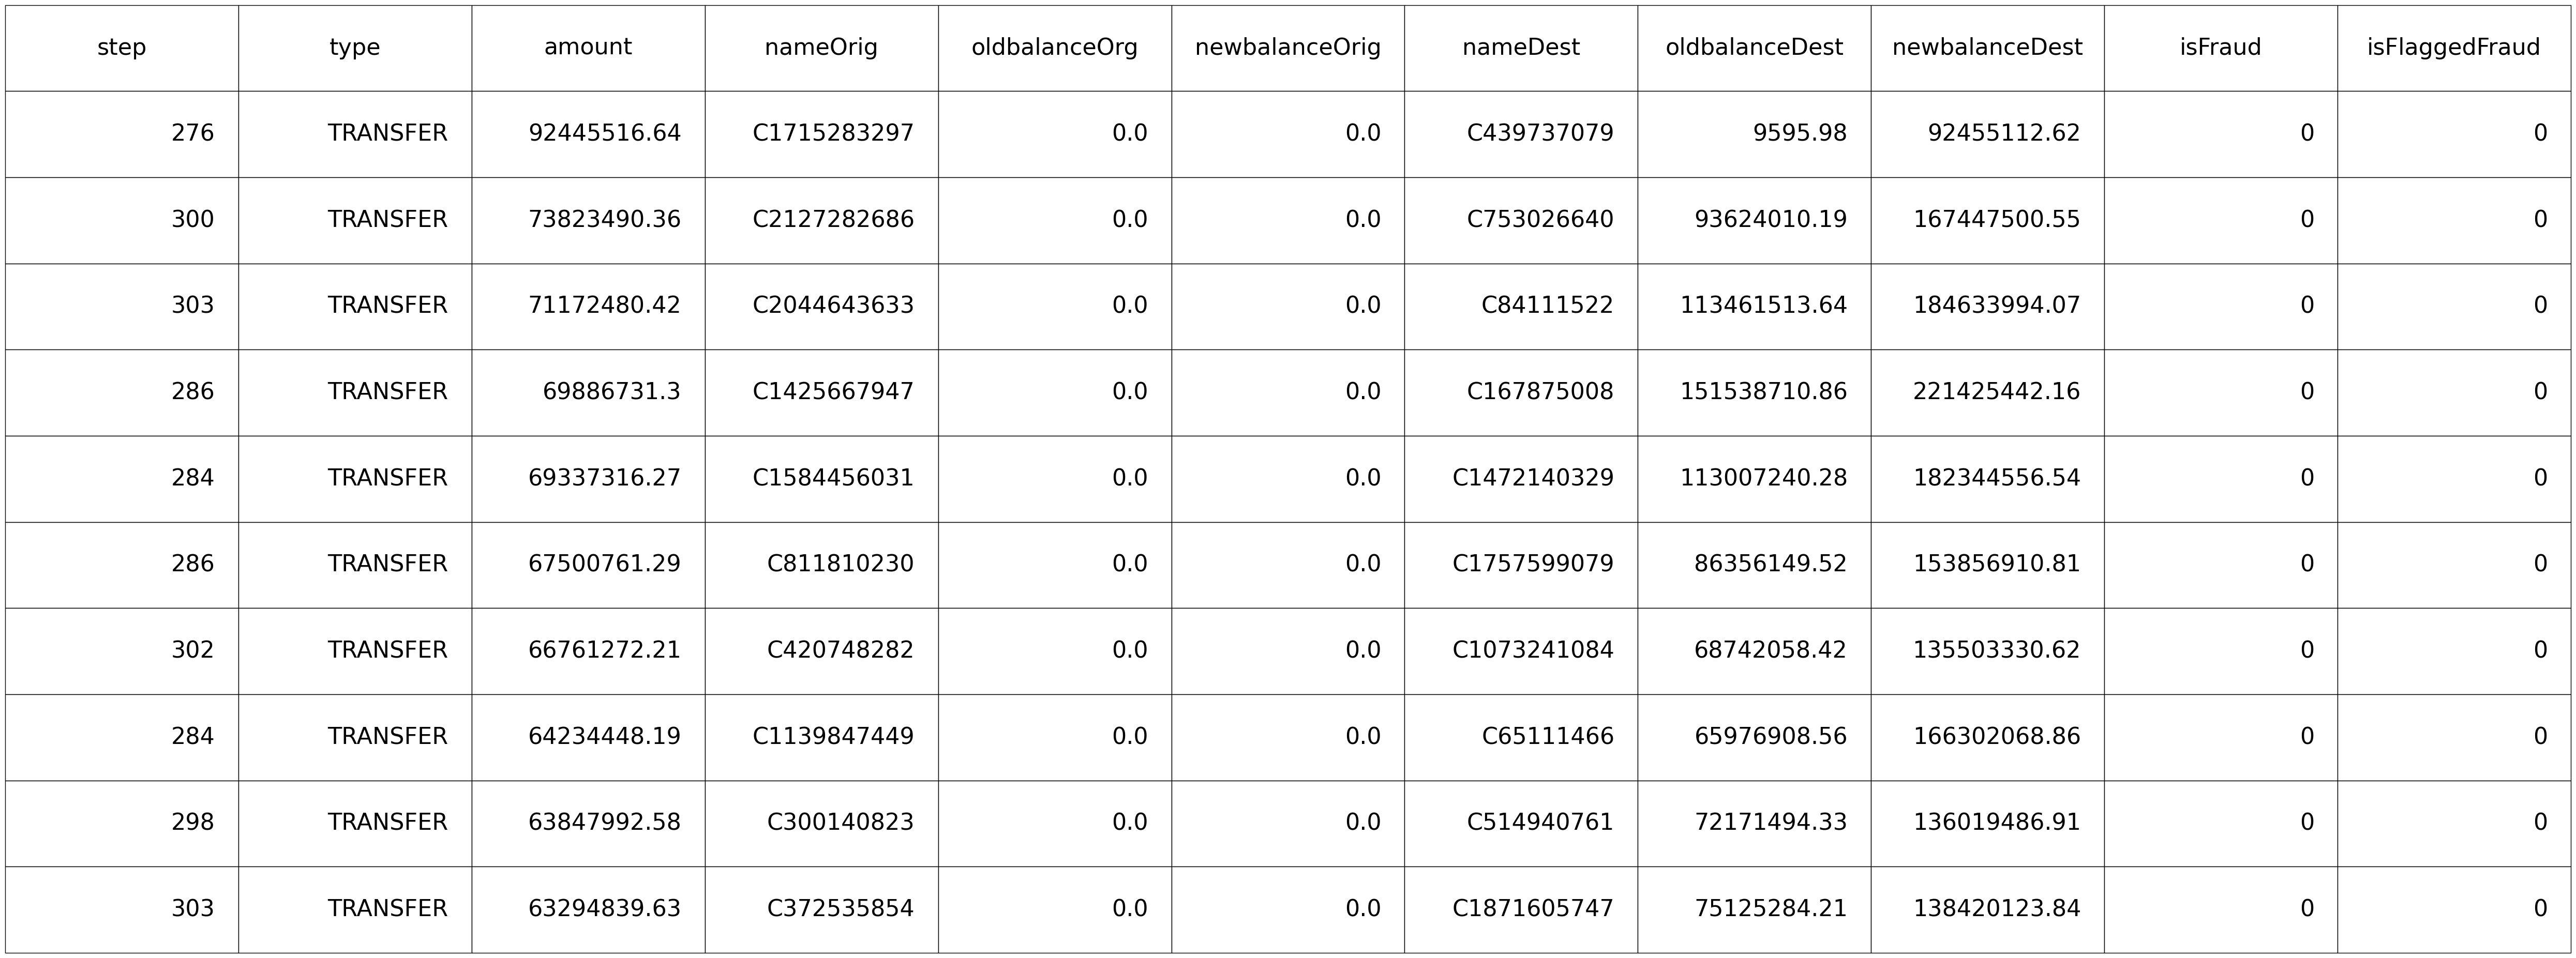

In [41]:
plot_table(train_set.nlargest(10, "amount"), 10)

As we can see from the plot above for the first 10 transactions, and also in the attached code for the first 100, neither of these is a fraud

In [42]:
x = train_set.nlargest(100, "amount").isFraud
counter = 0
if 1 in x.values:
    counter +=1
counter

0

We can conclude that frauds are happening in transactions that have low amount of money

#### oldBalanceOrig

We can plot the 10 largest balances of the dataset and compare them with the newBalanceOrig

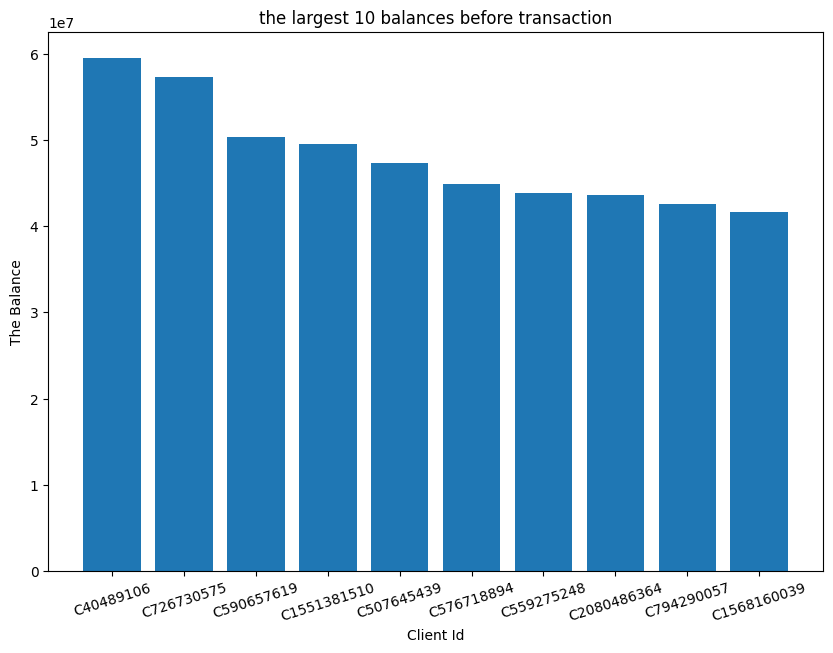

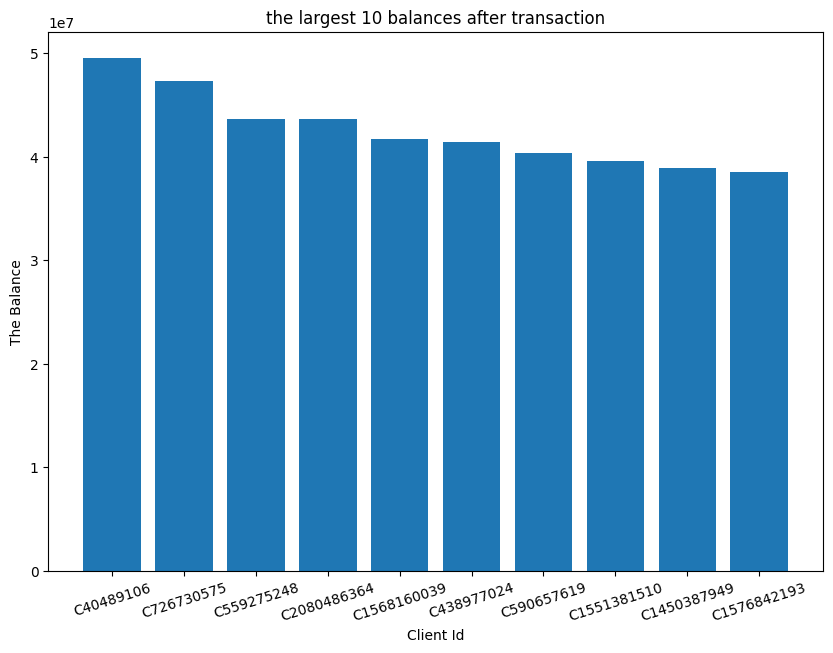

In [43]:
# Before Transaction
plt.figure(figsize = [10,7])
plt.bar(train_set.nlargest(10, 'oldbalanceOrg').nameOrig, train_set.nlargest(10, 'oldbalanceOrg').oldbalanceOrg)
plt.xticks(rotation = 17.5) # to give more spacing for IDs
plt.title('the largest 10 balances before transaction')
plt.xlabel('Client Id')
plt.ylabel('The Balance')
plt.show()

# After Transaction
plt.figure(figsize = [10,7])
plt.bar(train_set.nlargest(10, 'newbalanceOrig').nameOrig, train_set.nlargest(10, 'newbalanceOrig').newbalanceOrig)
plt.xticks(rotation = 17.5) # to give more spacing for IDs
plt.title('the largest 10 balances after transaction')
plt.xlabel('Client Id')
plt.ylabel('The Balance')
plt.show()

The first two clients remain the same.
We can also plot the distribution before and after the transaction about a sample between the two ranges.

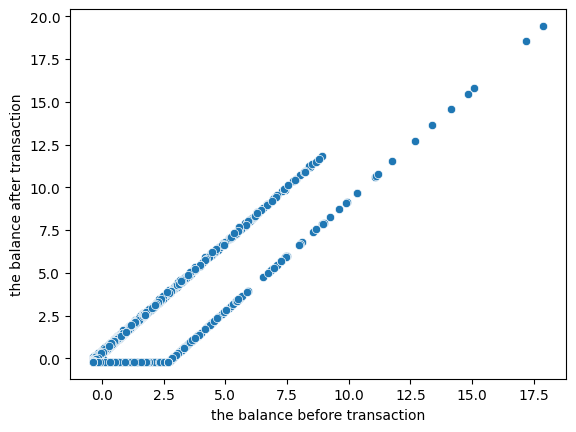

In [54]:
samp1 = train_set.sample(n = train_set.shape[0])

sb.scatterplot(x = samp1.oldbalanceOrg, y = samp1.newbalanceOrig)
plt.xlabel('the balance before transaction')
plt.ylabel('the balance after transaction')
plt.show()

### Finding correlations

In [45]:
train_set[['oldbalanceOrg', 'newbalanceOrig']].corr()

,oldbalanceOrg,newbalanceOrig
oldbalanceOrg,1.000000,0.998796
newbalanceOrig,0.998796,1.000000


The sampling distribution shows a strong positive correlation between the balance before and after the transaction.
Now let's have a look at the correlation between features of dataframe compared to the isFraud column.

isFraud           1.000000
amount            0.077064
isFlaggedFraud    0.046319
step              0.031646
oldbalanceOrg     0.010094
newbalanceDest    0.000570
oldbalanceDest   -0.005904
newbalanceOrig   -0.008276
Name: isFraud, dtype: float64


<AxesSubplot: >

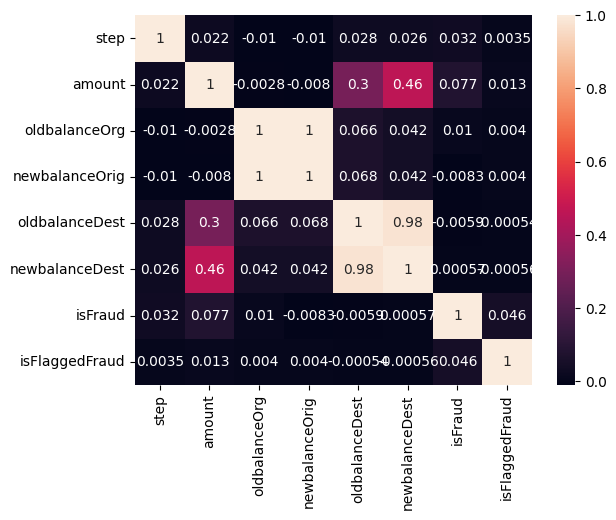

In [46]:
corr_isFraud = train_set.corr(numeric_only=True)
print(corr_isFraud["isFraud"].sort_values(ascending=False))

sb.heatmap(corr_isFraud, annot=True)

As we can see from these results and the observations we made in the previous chapter, it seems that isFraud is not strongly correlated with other columns.

## Preprocessing and Feature Selection

We check if there are any missing features in the dataset

In [47]:
print(train_set.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


As we can see there aren't null values in any feature, so we won't need to do some data cleaning.

We observed at the beginning that for the isFlaggedFraud column there's not much information, it is not clear what is it's purpose. We can see that it is utilized in the dataset only few times, so we drop it from the dataframe.
The correlation map also shows that there's no correlation between frauds and the customers IDs, so we can remove them.
To drop columns we need to create a custom Transformer

In [57]:
train_set["isFlaggedFraud"].value_counts()

KeyError: 'isFlaggedFraud'

### Balance Dataset

In [49]:
class_count_0, class_count_1 = train_set['isFraud'].value_counts()
class_0 = train_set[train_set['isFraud'] == 0]
class_1 = train_set[train_set['isFraud'] == 1]

class_0_under = class_0.sample(class_count_1)
train_set = pd.concat([class_0_under, class_1], axis=0)

In [50]:
class columnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 

Next we create a Pipeline of transformations we need to execute on our data, this way we can have a predefined course also for new data before we can fit the model

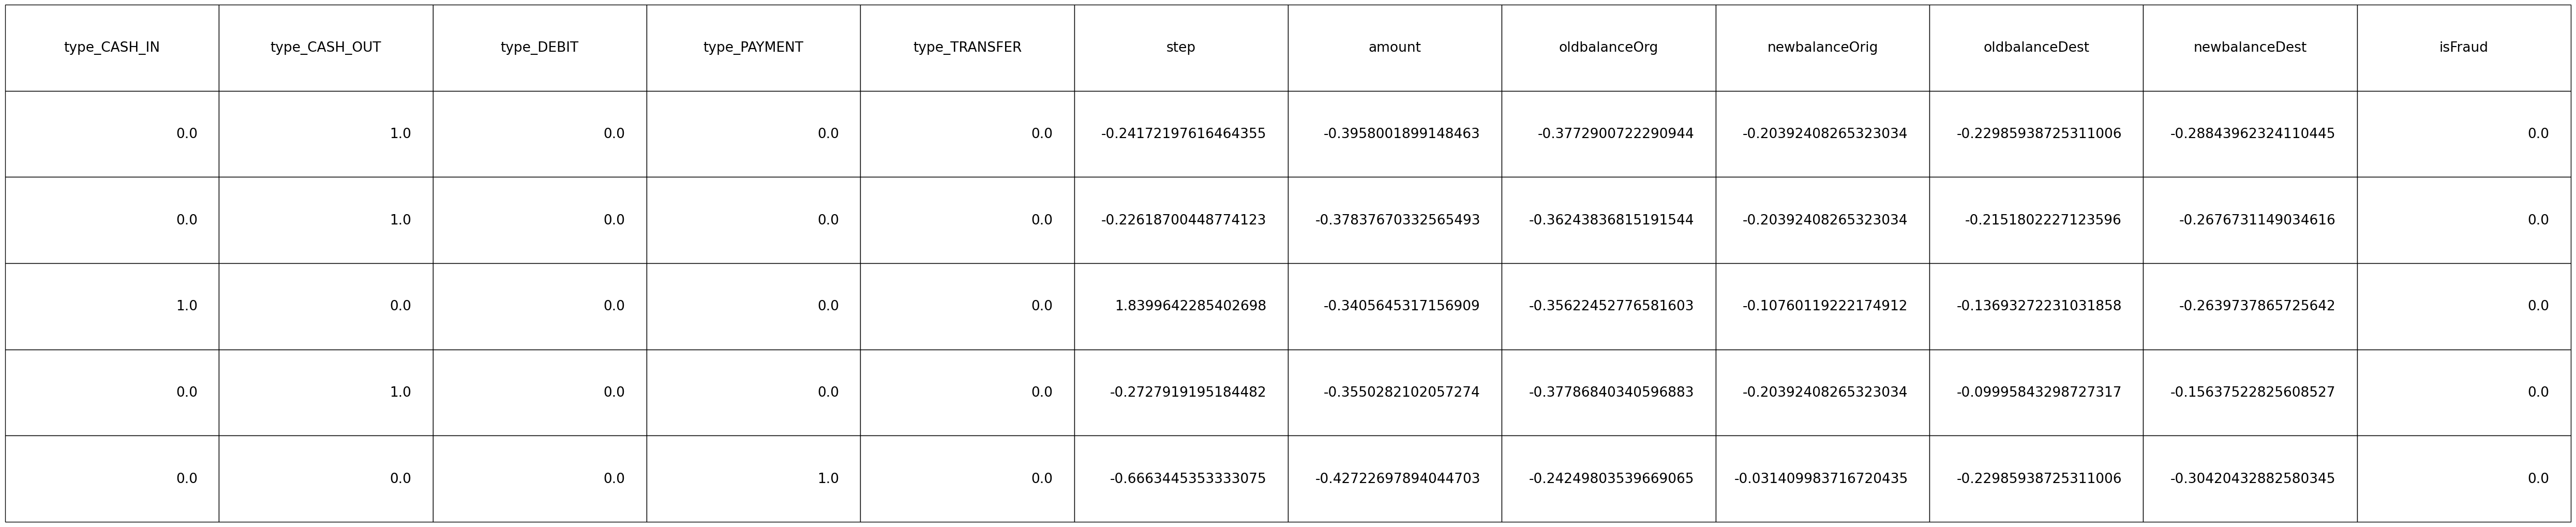

In [51]:
# This pipeline handles both numerical and categorical data
# But it also returns a numpy array instead of a dataframe, so we need to do some tricks
cat_attribs = ["type"]
num_attribs = ["step", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
drop_attribs = ['isFlaggedFraud', 'nameOrig', 'nameDest']

full_pipeline = ColumnTransformer([
    ("dropCol", "drop", drop_attribs),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs),
    ("num", StandardScaler(), num_attribs)
], verbose_feature_names_out=False, remainder='passthrough')

train_set = pd.DataFrame(full_pipeline.fit_transform(train_set), columns=full_pipeline.get_feature_names_out())
plot_table(train_set, 5)

## Models Comparison

Let's train some models and compare them, for this project we will use:
- Logistic Regression
- Random Forest
- MLP Neural Network

We will also use cross validation

### First struggles

As soon as we start training our models for the first time we understand that the models initialization will need some tweaks to decrease the complexity and build time. In our host machine the program was taking up to 3GB of RAM and 10 minutes to build even the simplest Logistic Regressor. So we limit the iterations needed by the model to converge to 300, we start training again and we get the following results

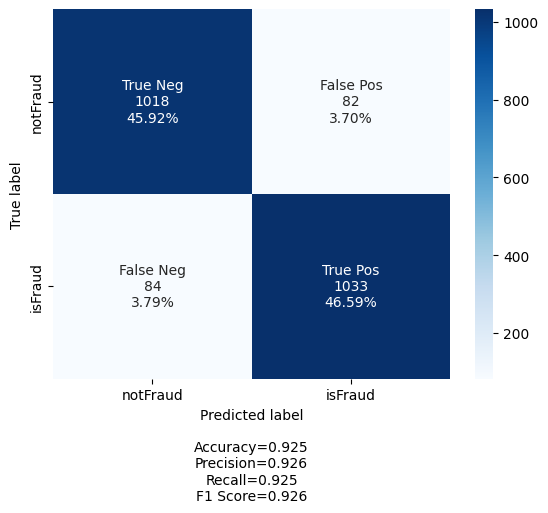

In [20]:
y = train_set.loc[:, "isFraud"]
X = train_set.loc[:, train_set.columns != "isFraud"]
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["notFraud", "isFraud"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)

model = LogisticRegression(max_iter=300)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
cf_matrix = confusion_matrix(y_val, y_pred)
make_confusion_matrix(cf_matrix, group_names=labels, categories=categories)

The accuracy is very high, but if we look at the Confusion Matrix we notice that we predict almost all the "notFraud" transaction correctly, but also that we do not classify the fraudulent ones at all! Basically the model learnt to always predict the notFraud class without doing any analysis, because this is the most convenient way to minimize the Loss Function. This can also be noted by looking at the Recall Score, which is very low, meaning that the classifier failed to predict the minority class label. 
We can show this even better by doing the training only on one column

In [21]:
# y = train_set.loc[:, "isFraud"]
# X_reduced = train_set.loc[:, ["amount"]]

# X_train, X_val, y_train, y_val = train_test_split(X_reduced, y, test_size=0.15)

# model = LogisticRegression(max_iter=300)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_val)
# cf_matrix = confusion_matrix(y_val, y_pred)
# make_confusion_matrix(cf_matrix, group_names=labels, categories=categories)

As we can see from the results the accuracy is still very high, and the confusion matrix is almost identical. This is happening because we have a highly imbalanced dataset, meaning that the occurrencies where "isFraud" is 0 are almost 27 times more than where "isFraud" is 1. We try to deal with this imbalance by applying resampling.
We can use the "imblearn" library to apply both undersampling and oversampling, but first we want to visualize this dataset imbalance by plotting it in a 2D space. To do so we need to use a Dimensionality Reduction technique, PCA in this case, because the dataset has many dimensions.

In [22]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

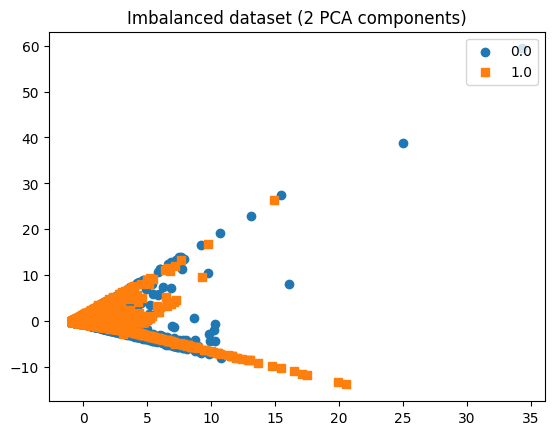

In [23]:
colors = ['#1F77B4', '#FF7F0E']
markers = ['o', 's']
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)
plot_2d_space(X_pca, y, 'Imbalanced dataset (2 PCA components)')

Even if this techniques balance the dataset, they also have their weknesses. For example oversampling will increase the risk of overfitting, and undersampling will increase the risk of information loss.
Executing undersampling combined with oversampling revealed to be more difficult than I initially thought. After 20 minutes of running without any result and after tweaking various versions of both sklearn and imblearn without any improvement I decided to just do undersampling with basic pandas functions.

In [24]:
# y = train_set.loc[:, "isFraud"]
# X = train_set.loc[:, train_set.columns != "isFraud"]
# X = train_set.loc[:, ["amount"]]
kf = KFold(n_splits=10)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)

In [25]:
y = train_set.loc[:, "isFraud"]
X = train_set.loc[:, train_set.columns != "isFraud"]

Then we define the list of models we want to evaluate

In [26]:
models = {
    "LR": LogisticRegression(max_iter=300),
    "RF": RandomForestClassifier(max_depth=4, n_estimators=100),
}

In [27]:
final_scores = np.zeros((2, 4)) # each row: accuracy, recall, precision, f1
i = 0 # model index

for name, model in models.items():
    k = 0
    model_scores = np.zeros((10, 4)) # each row: accuracy, recall, precision, f1
    print(f'Training Model {name} \n--------------')
    for train_index, val_index in kf.split(X, y):
        # get the actual arrays
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        # train model and get prediction
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        model_scores[k][0] = accuracy_score(y_val, y_pred)
        model_scores[k][1] = recall_score(y_val, y_pred, average='micro')
        model_scores[k][2] = precision_score(y_val, y_pred, average='micro')
        model_scores[k][3] = f1_score(y_val, y_pred, average='micro')
        k += 1
    
    final_scores[i][0] = model_scores[:, 0].mean()
    final_scores[i][1] = model_scores[:, 1].mean()
    final_scores[i][2] = model_scores[:, 2].mean()
    final_scores[i][3] = model_scores[:, 3].mean()

    print(f"Avarage accuracy:  {final_scores[i][0]}")
    print(f"Avarage recall:  {final_scores[i][1]}")
    print(f"Avarage precision:  {final_scores[i][2]}")
    print(f"Avarage f1:  {final_scores[i][3]}")

Training Model LR 
--------------
Avarage accuracy:  0.9002444794013394
Avarage recall:  0.9002444794013394
Avarage precision:  0.9002444794013394
Avarage f1:  0.9002444794013392
Training Model RF 
--------------
Avarage accuracy:  0.9493782426617242
Avarage recall:  0.9493782426617242
Avarage precision:  0.9493782426617242
Avarage f1:  0.9493782426617242


### Neural Networks

In previous chapters we only used ML models, now we introduce our final DNN model and compare its performance with the others. In this project we use Tensorflow and Keras, so let's create a base model that later will be tweaked.
The structure is the following:
- input layer with 11 neurons because our X dataframe has 11 columns
- a hidden layer of 100 neurons. This will be tweaked afterwards, but a paper found out that it's better to create several hidden layers with the same number of neurons than having a single layer with a lot of neurons
- the output layer containing a single layer because this is a binary classification task

For a binary classification task it is more suitable a binary cross entropy Loss Function, and the Adam algorithm for gradient descent.

In [28]:
def create_baseline(hp=None):
	# create model
	model = tf.keras.Sequential()
	model.add(tf.keras.layers.Dense(11, input_shape=(11,), activation='relu')) # input layer
	if hp:
		hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
		model.add(tf.keras.layers.Dense(units=hp_units, activation="relu"))
	else:
		model.add(tf.keras.layers.Dense(100, activation="relu"))
	model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # output layer
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [29]:
models = {
    "LR": LogisticRegression(max_iter=300),
    "RF": RandomForestClassifier(max_depth=4, n_estimators=100),
    "MLP": KerasClassifier(model=create_baseline(), epochs=30),
}

kfold = StratifiedKFold(n_splits=10, shuffle=True)
scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_micro': 'recall_macro'}

2022-11-06 17:40:43.774602: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
final_scores = pd.DataFrame()
for name, model in models.items():
    print(f'Training Model {name} \n--------------')
    # This scores are for each fold
    scores = cross_validate(model, X, y, scoring=scoring,
                         cv=10, return_train_score=True)
    final_scores = pd.concat([final_scores, pd.DataFrame([{"models": name, "accuracy": scores['test_acc'].mean()}])])

Training Model LR 
--------------
Training Model RF 
--------------
Training Model MLP 
--------------
Epoch 1/30
416/416 [==============================] - 1s 746us/step - loss: 0.3609 - accuracy: 0.8419
Epoch 2/30
416/416 [==============================] - 0s 734us/step - loss: 0.2618 - accuracy: 0.8802
Epoch 3/30
416/416 [==============================] - 0s 716us/step - loss: 0.2385 - accuracy: 0.8916
Epoch 4/30
416/416 [==============================] - 0s 714us/step - loss: 0.2148 - accuracy: 0.9007
Epoch 5/30
416/416 [==============================] - 0s 712us/step - loss: 0.1968 - accuracy: 0.9110
Epoch 6/30
416/416 [==============================] - 0s 715us/step - loss: 0.1829 - accuracy: 0.9190
Epoch 7/30
416/416 [==============================] - 0s 749us/step - loss: 0.1746 - accuracy: 0.9231
Epoch 8/30
416/416 [==============================] - 0s 712us/step - loss: 0.1680 - accuracy: 0.9256
Epoch 9/30
416/416 [==============================] - 0s 721us/step - loss: 0.159

In [31]:
# plot results
final_scores

,models,accuracy
0,LR,0.922037
0,RF,0.959868
0,MLP,0.958650


#### Hyperparameter optimization with KerasTuner

Now that we chose the Multi Layer Perceptron as our final model we can tweak some hyperparameters like the number of hidden layers, number of neurons for each layer, number of epochs for achieving better results. Doing so manually is inefficient and painful, so we can use the recommended libray for Keras called KerasTuner.

In [32]:
tuner = keras_tuner.RandomSearch(create_baseline, objective='val_accuracy')
tuner.search(X, y, epochs=50, validation_split=0.2)
best_model = tuner.get_best_models()[0]

In [33]:
# prepare test set
# apply transformation also to test set
test_set = pd.DataFrame(full_pipeline.transform(test_set), columns=full_pipeline.get_feature_names_out())
y_test = test_set.loc[:, "isFraud"]
X_test = test_set.loc[:, test_set.columns != "isFraud"]

# train choosen model
best_model.fit(X_train, y_train)

# make predictions for test data and print evaluation
eval_res = best_model.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_res)

19884/19884 [==============================] - 11s 536us/step - loss: 0.0472 - accuracy: 0.9872
[test loss, test accuracy]: [0.0471799336373806, 0.9872254133224487]
